In [16]:
#Workbench imports
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import brentq

from workbench_version import * #load the model

from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

from ema_workbench import(ema_logging, perform_experiments)
from ema_workbench import MultiprocessingEvaluator

In [17]:
#### LOAD ADAPTATION STRATEGIES ####
from mayors import *
allMayors = [Reactive(),Economicus(),Sentiment(),Lawkeeper()]

In [18]:
from ema_workbench import(RealParameter,ScalarOutcome, Constant, BooleanParameter, CategoricalParameter, IntegerParameter,
                          Model, TimeSeriesOutcome)

model = Model('Rotty',function=run_model_workbench)

model.uncertainties = [CategoricalParameter('SLR',categories=['01','02','03','04',
                                                              '05','06','07','08','09']),
                       IntegerParameter('transient',lower_bound=0,upper_bound=19),
                       CategoricalParameter('Housing_market', #only for control of temp scalar outcome
                                            categories=['rational','boundedly_rational'])]


model.levers = [CategoricalParameter('Mayor',categories=allMayors)]

model.outcomes = [#TimeSeriesOutcome('HP_hp_t_obj'),
                  #TimeSeriesOutcome('HP_hp_t_sub'),
                  #TimeSeriesOutcome('CC_hp_t_obj'),
                  #TimeSeriesOutcome('CC_hp_t_sub'),
                  ScalarOutcome('HP_hp_2200_obj'),
                  ScalarOutcome('HP_hp_2200_sub'),
                  ScalarOutcome('CC_hp_2200_obj'),
                  ScalarOutcome('CC_hp_2200_sub'),
                  ScalarOutcome('HP_first_SETP'),
                  ScalarOutcome('CC_first_SETP'),]

In [19]:
ema_logging.log_to_stderr(ema_logging.INFO)

#experiments, outcomes = perform_experiments(models=model,scenarios=500,policies=4)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=500,policies=4)
experiments, outcomes = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [20]:
experiments['Mayor'] = experiments['Mayor'].apply(lambda M: M.get_name())

In [21]:
experiments2 = experiments.copy()
map_house_market = {'rational' : 0, 
             'boundedly_rational' :1}
map_mayor = {'H. Economicus': 0,
             'Sentiment' : 1,
             'R. Active' : 2,
             'Lawkeeper' : 3}
experiments2['Housing_market'].replace(map_house_market,inplace=True)
experiments2['Mayor'].replace(map_mayor,inplace=True)
experiments2[['Housing_market', 'SLR', 'transient', 'Mayor', 'policy']].astype('float')

,Housing_market,SLR,transient,Mayor,policy
0,0.0,7.0,6.0,0.0,0.0
1,1.0,4.0,10.0,0.0,0.0
2,0.0,5.0,11.0,0.0,0.0
3,0.0,5.0,7.0,0.0,0.0
4,0.0,1.0,10.0,0.0,0.0
...,...,...,...,...,...
1995,1.0,4.0,11.0,2.0,3.0
1996,1.0,2.0,8.0,2.0,3.0
1997,1.0,1.0,17.0,2.0,3.0
1998,1.0,1.0,0.0,2.0,3.0


In [22]:
pd.DataFrame(outcomes).head()

,HP_hp_2200_obj,HP_hp_2200_sub,CC_hp_2200_obj,CC_hp_2200_sub,HP_first_SETP,CC_first_SETP
0,139750.279443,139750.279443,348021.919456,348021.919456,9999,9999
1,0.000000,0.000000,348747.951849,348747.951849,2054,9999
2,0.000000,0.000000,347566.827172,347566.827172,2126,9999
3,0.000000,0.000000,347566.827172,347566.827172,2126,9999
4,0.000000,0.000000,348590.862578,348590.862578,2076,9999


# Scenario discovery with first_SETP indicator

In [53]:
%matplotlib inline

from ema_workbench.analysis import prim
x = experiments2
y = outcomes['CC_first_SETP'] < 2200
prim_alg = prim.Prim(x,y,threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 2000 points remaining, containing 299 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.079, coverage: 0.5284280936454849, density: 1.0 restricted_dimensions: 4


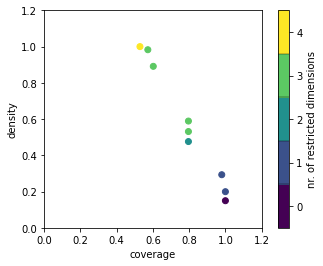

In [54]:
%matplotlib inline
box1.show_tradeoff()
plt.show()

#Eerste puntje: Mayor 0-2: dus uitsluiten van Mayor Lawkeeper
#Tweede puntje: Mayor 1-2: dus uitsluiten van Mayor Sentiment
#Derde puntje (box): 3: dus uitsluiten van rationele woningmarkt
# 4 tot 6: beperken zeespiegelscenario

In [83]:
box1.inspect(6)

coverage    0.602007
density     0.891089
id                 6
mass           0.101
mean        0.891089
res_dim            3
Name: 6, dtype: object

                                       box 6                                \
                                         min                           max   
Mayor                                      2                             2   
Housing_market                             1                             1   
SLR             {04, 05, 06, 07, 01, 03, 02}  {04, 05, 06, 07, 01, 03, 02}   

                                                                 
                                                      qp values  
Mayor           [1.4155800907637223e-47, 2.299060854854275e-40]  
Housing_market                    [9.717164524208377e-20, -1.0]  
SLR                              [2.9345530380172798e-09, -1.0]  



coverage    0.795987
density     0.589109
id                 5
mass           0.202
mean        0.589109
res_dim            3
Name: 5, dtype: object

                                       box 5                                \
                                         min                           max   
Housing_market                             1                             1   
Mayor                                      1                             2   
SLR             {04, 05, 06, 07, 01, 03, 02}  {04, 05, 06, 07, 01, 03, 02}   

                                                                 
                                                      qp values  
Housing_market                    [4.427873987037059e-18, -1.0]  
Mayor           [3.286167418195369e-14, 1.2989242710613305e-15]  
SLR                              [3.3192902654510847e-06, -1.0]  



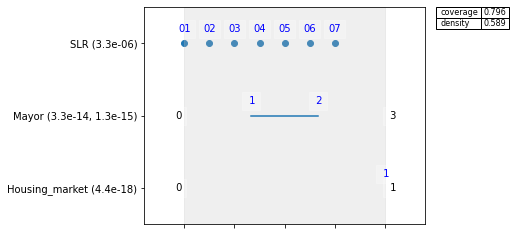

In [85]:
box1.inspect(5)
box1.inspect(5, style='graph')
plt.show()

In [ ]:
box1.show_pairs_scatter(2)
plt.show()

### Feature scoring

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


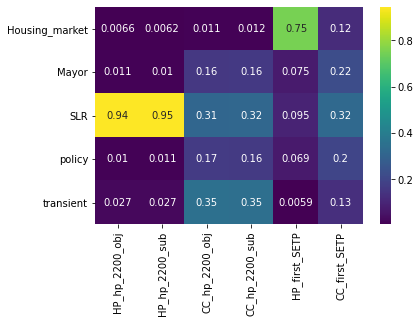

In [87]:
from ema_workbench.analysis import feature_scoring
x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

In [89]:
x = experiments
y = outcomes['CC_first_SETP'] < 2150

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

AttributeError: module 'ema_workbench.analysis.feature_scoring' has no attribute 'CLASSIFICATION'

,Housing_market,SLR,transient,Mayor,model
0,rational,02,8.0,H. Economicus,Rotty
1,boundedly_rational,07,18.0,H. Economicus,Rotty
2,boundedly_rational,05,10.0,H. Economicus,Rotty
3,rational,03,16.0,H. Economicus,Rotty
4,boundedly_rational,09,5.0,H. Economicus,Rotty
...,...,...,...,...,...
1995,boundedly_rational,01,14.0,Lawkeeper,Rotty
1996,rational,04,13.0,Lawkeeper,Rotty
1997,rational,07,16.0,Lawkeeper,Rotty
1998,rational,08,10.0,Lawkeeper,Rotty


### Dimensional stacking: City Centre

[MainProcess/INFO] model dropped from analysis because only a single category


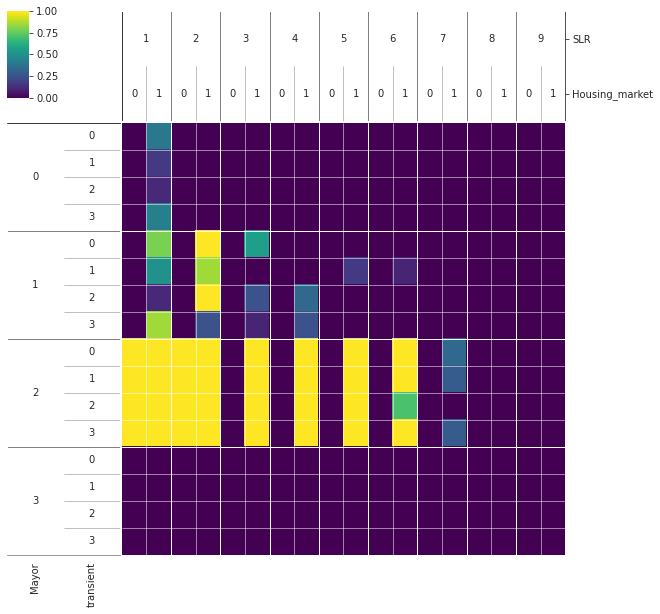

In [30]:
from ema_workbench.analysis import dimensional_stacking

x = experiments2.drop('policy',axis=1)
y = outcomes['CC_first_SETP'] <2200
#y = outcomes['CC_first_SETP'] 

fig = dimensional_stacking.create_pivot_plot(x,y, 2, nbins=4,categories=True)


What can we learn from the above picture?

Under Mayor 2 *Reactive*, the concentration of SETPs is the highest. Under SLR scenario 1 and 2 they happen in both type of housing market. From SLR scenario 3 to 7 they only happen in a boundedly rational housing market. 

Under Mayor 1 *Sentiment*, tipping points may still occur in a boundedly rational housing market, mainly under SLR scenario 1-4. Here, the transient scenario also starts to play a mayor role.

Under Mayor 3 *Economicus*, there stil is a small likelihood of tipping points in a boundedly rational housing market, combined with the most extreme sea level rise scenario.

Even in the most extreme SLR scenario 1, tipping points can be still be avoided under mayor *Lawkeeper*

### Dimensional stacking: Heijplaat tips before 2100

[MainProcess/INFO] model dropped from analysis because only a single category


dict_keys(['_stale', 'stale_callback', 'figure', '_transform', '_transformSet', '_visible', '_animated', '_alpha', 'clipbox', '_clippath', '_clipon', '_label', '_picker', '_contains', '_rasterized', '_agg_filter', '_mouseover', 'eventson', '_oid', '_propobservers', '_remove_method', '_url', '_gid', '_snap', '_sketch', '_path_effects', '_sticky_edges', '_in_layout', 'callbacks', 'bbox_inches', 'dpi_scale_trans', '_dpi', 'bbox', 'transFigure', 'patch', 'canvas', '_suptitle', 'subplotpars', '_layoutbox', '_constrained_layout_pads', '_constrained', '_tight', '_tight_parameters', '_axstack', 'suppressComposite', 'artists', 'lines', 'patches', 'texts', 'images', 'legends', '_axobservers', '_cachedRenderer', '_align_xlabel_grp', '_align_ylabel_grp', '_gridspecs', 'number'])

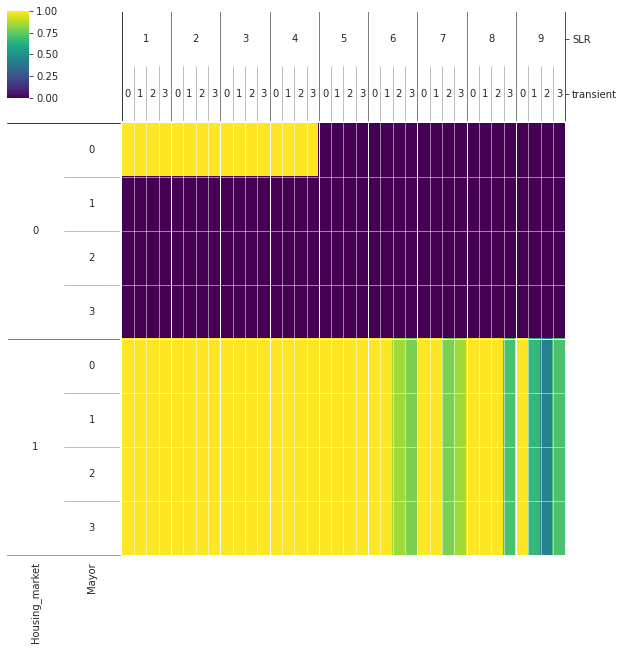

In [29]:
x = experiments2.drop('policy',axis=1)
y = outcomes['HP_first_SETP'] <2100
#y = outcomes['CC_first_SETP'] 

fig = dimensional_stacking.create_pivot_plot(x,y, 2, nbins=4,categories=True)

Interpretation: in a boundedly rational housing market, there will almost certainly be a tipping point before 2100 in the Heijplaat. With a low degree of SLR (scenario 6-9), the city might survive, but this depends on the transient storm surge scenarios.

Note that this does not necessarily mean that in the other scenarios the house price does not go to zero!!!! It just indicates that this does not go ABRUPT, tipping-point like.

In a rational housing market, there will only be tipping points under very high sea level rise scenarios and Mayor 0 (Economicus).

### Regional sensitivity analysis

In [124]:
experiments2['SLR'] = experiments2['SLR'].astype('float')

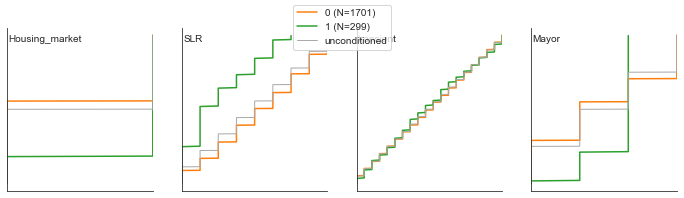

In [125]:
sns.set_style('white')

# model is the same across experiments
x = experiments2.copy()
x = x.drop(['model','policy'], axis=1)
y = outcomes['CC_first_SETP'] <2200
fig = regional_sa.plot_cdfs(x,y)
sns.despine()
plt.show()

# Sobol-indices (does not work)

In [ ]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, policies=['Sentiment'],
                                               uncertainty_sampling='sobol')

experiments, outcomes = sa_results

In [ ]:
problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes['max_P'],
                   calc_second_order=True, print_to_console=False)

# Old stuff

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "
[MainProcess/INFO] no time dimension found in results


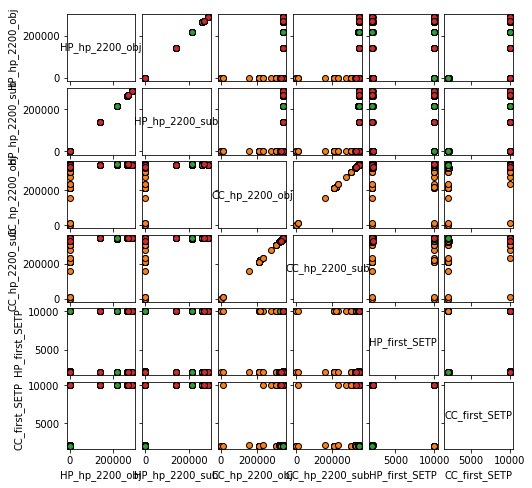

In [7]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy',
                                         legend=False)
fig.set_size_inches(8,8)
plt.show()

In [8]:
from ema_workbench.analysis import feature_scoring

x = pd.DataFrame(experiments)
y = pd.DataFrame(outcomes)

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

TypeError: '<' not supported between instances of 'Reactive' and 'Lawkeeper'

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

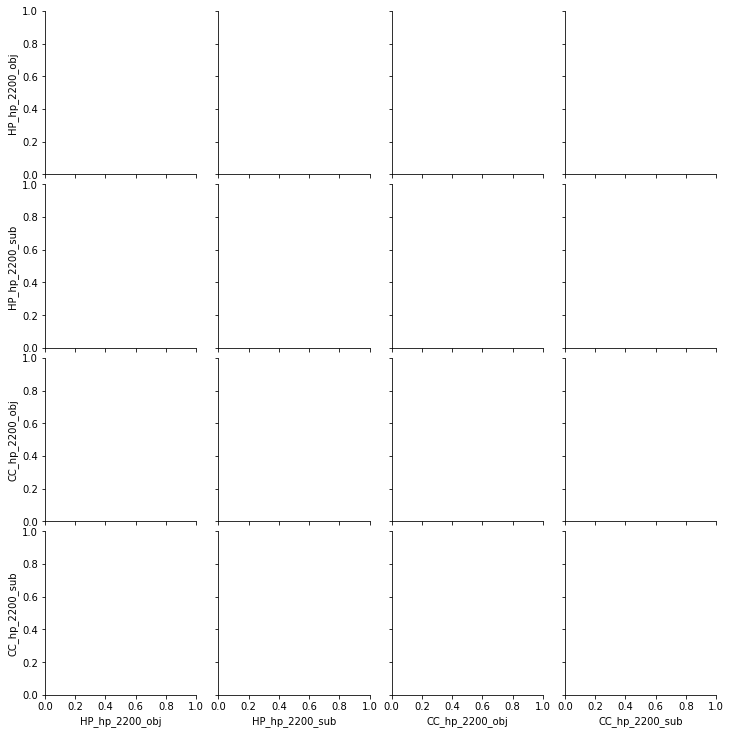

In [21]:
policies = experiments['policy']
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies


sns.pairplot(data, hue='policy', vars=list(outcomes.keys()))
plt.show()

In [13]:
experiments.Mayor.unique()

array([<mayors.Reactive object at 0x000001D502353A60>,
       <mayors.Lawkeeper object at 0x000001D502353E80>], dtype=object)

In [14]:
experiments2 = experiments.copy()
experiments2['SLR']=  experiments2['RCP'] + "_" + experiments2['collapse'].map(str) + "_"  + experiments2['PDF'].map(str)
experiments2

KeyError: 'RCP'

In [92]:
slr_scenarios = experiments2['SLR']
#unique = np.unique(slr_scenarios)
#for i, slr in enumerate(unique):
#     experiments2.loc[slr_scenarios==slr, 'SLR'] = str(i) #replace  by integer
data = pd.DataFrame(outcomes)
data['slr_scenarios'] = slr_scenarios
#data['slr_scenarios']
data.iloc[:,4]

0        RCP85_True_50
1        RCP85_True_17
2       RCP26_False_17
3       RCP26_False_17
4        RCP85_True_17
             ...      
3995     RCP26_True_17
3996    RCP26_False_50
3997    RCP26_False_17
3998    RCP85_False_50
3999     RCP26_True_50
Name: slr_scenarios, Length: 4000, dtype: object

In [98]:
data.sort_values(by='slr_scenarios',inplace=True)

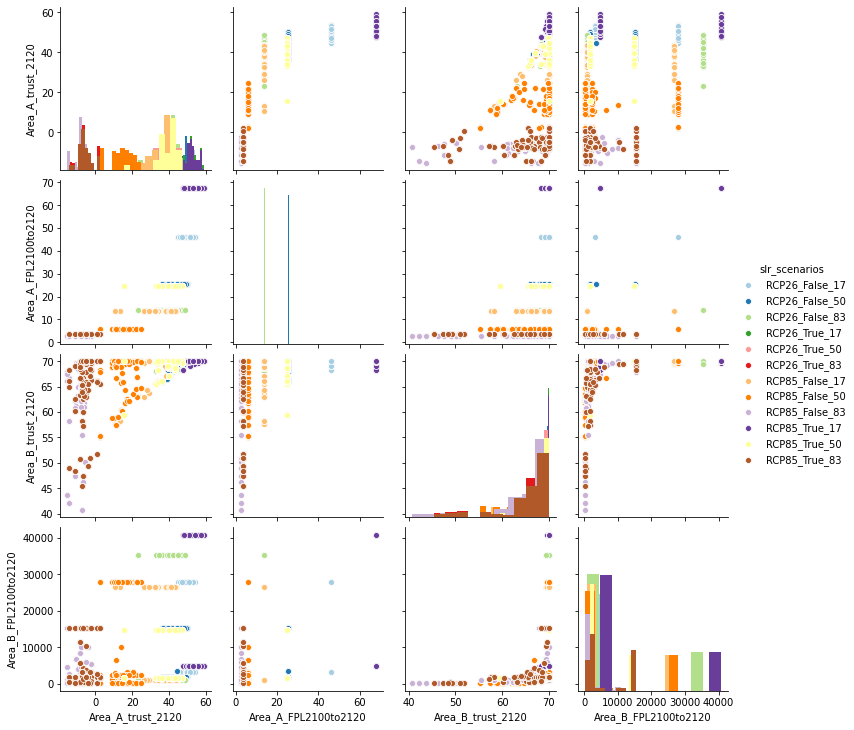

In [104]:
sns.pairplot(data, hue='slr_scenarios',vars=list(outcomes.keys()),diag_kind='hist',palette='Paired')

In [ ]:
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies


sns.pairplot(data, hue='policy', vars=list(outcomes.keys()))
plt.show()

[MainProcess/INFO] no time dimension found in results


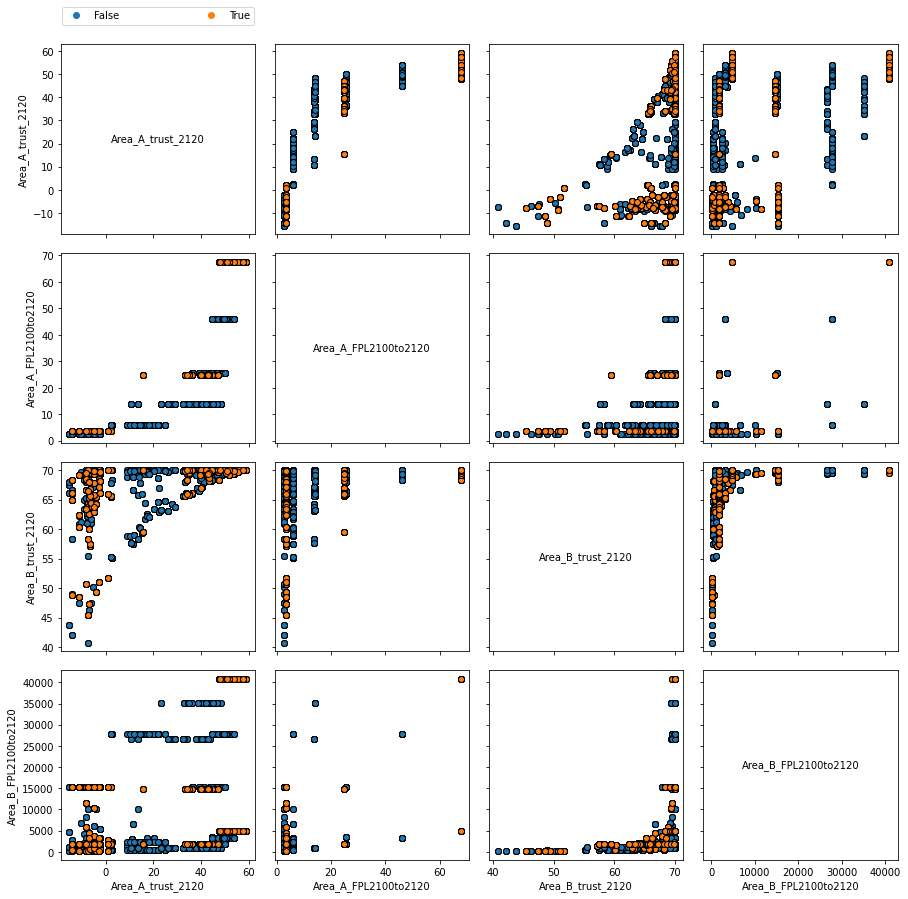

In [28]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='collapse',
                                         legend=True)
fig.set_size_inches(15,15)
plt.show()

In [22]:
outcomes

{'Area_A_trust_2120': array([45.08716481, 55.53645285, 51.64224843, ..., 53.90578306,
        11.96904438, 34.07296084]),
 'Area_A_FPL2100to2120': array([24.76569913, 67.62419361, 46.17610852, ..., 46.17610852,
         5.92469669, 24.76569913]),
 'Area_B_trust_2120': array([69.92675009, 69.64431336, 69.1611392 , ..., 69.45103983,
        69.81192545, 65.99996165]),
 'Area_B_FPL2100to2120': array([1741.85920216, 4818.09541286, 3278.66657571, ..., 3278.66657571,
        2403.91616273, 1741.85920216])}

In [26]:
from ema_workbench.analysis import feature_scoring
x = experiments
y = outcomes



AttributeError: module 'ema_workbench.analysis.feature_scoring' has no attribute 'CLASSIFICATION'